# ARIMA 분석방법론을 통해 시계열의 변동형태를 파악하고 따릉이 자전거의 평균 속도를 예측하자

## 2020년도 1월 1일부터 2월 12일 까지의 따릉이 대여이력을 중심으로 구축

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import time
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# matplotlib 한글 설정

%matplotlib inline
import matplotlib.pyplot as plt
import sys

from matplotlib import font_manager, rc

if sys.platform == 'darwin' :
    path = '/Library/Fonts/AppleGothic.ttf'
elif sys.platform == 'win32' :
    path = "c:/Windows/Fonts/malgun.ttf"
else:
    print('Unknown system... sorry~~~')
    
font_name = font_manager.FontProperties(fname = path).get_name()
rc('font', family = font_name)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
%time bike = pd.read_csv('공공자전거 대여이력 정보_2020.01_056.csv', sep = ',')

Wall time: 1.53 s


In [4]:
print(bike.shape)
print('--------\n')
print(bike.info())
print('--------\n')
print(bike.isnull().sum())

(1048575, 11)
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   자전거번호     1048575 non-null  object
 1   대여일시      1048575 non-null  object
 2   대여 대여소번호  1048575 non-null  int64 
 3   대여 대여소명   1048575 non-null  object
 4   대여거치대     1048575 non-null  int64 
 5   반납일시      1048575 non-null  object
 6   반납대여소번호   1048575 non-null  int64 
 7   반납대여소명    1048575 non-null  object
 8   반납거치대     1048575 non-null  int64 
 9   이용시간      1048575 non-null  int64 
 10  이용거리      1048575 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 88.0+ MB
None
--------

자전거번호       0
대여일시        0
대여 대여소번호    0
대여 대여소명     0
대여거치대       0
반납일시        0
반납대여소번호     0
반납대여소명      0
반납거치대       0
이용시간        0
이용거리        0
dtype: int64


In [5]:
bike.head(5)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-04061,2020-01-01 0:01,429,송도병원,2,2020-01-01 0:04,372,약수역 3번출구 뒤,8,2,0
1,SPB-06686,2020-01-01 0:02,1637,KT 노원점 건물 앞,14,2020-01-01 0:04,1656,중앙하이츠 아파트 입구,9,1,350
2,SPB-15937,2020-01-01 0:01,1924,삼부르네상스파크빌,10,2020-01-01 0:05,1955,디지털입구 교차로,7,4,800
3,SPB-14805,2020-01-01 0:03,437,대흥역 1번출구,1,2020-01-01 0:05,126,서강대 후문 옆,18,2,0
4,SPB-09038,2020-01-01 0:01,1168,마곡엠밸리10단지 앞,5,2020-01-01 0:05,1152,마곡역교차로,2,4,660


In [6]:
# 데이터전처리 단계를 통해 결측치를 처리하고 분석이 가능한 상태로 데이터를 변모시킨다.
# 자전거의 이용거리와 이용시간을 나누어 평균 이동속도를 산출하고,
# 자전거번호만을 입력해 원하는 자료를 찾을 수 있도록 앞의 영어를 없애 간단화했으며
# 대여일시 피처를 시계열 피처로 변환한 다음, 인덱스로 지정한다.

bike['평균 이동속도 (meters/minutes)'] = bike['이용거리'] / bike['이용시간']
bike['자전거번호'] = bike['자전거번호'].apply(lambda x: x[-5:])
bike['대여일시'] = pd.to_datetime(bike['대여일시'])
bike.index = bike['대여일시']
bike.set_index('대여일시', inplace=True)

In [7]:
# 자전거 번호를 입력하면 번호에 맞추어 맞춤형 데이터를 산출하여 정리한다.

bike_number = str(input())
bike_num = bike[bike['자전거번호'] == bike_number][['평균 이동속도 (meters/minutes)']]
bike_num.shape

14251


(104, 1)

In [8]:
# 데이터를 학습데이터와 테스트 데이터로 구분해 데이터 전처리 단계를 끝마춘다.

bike_train = bike_num.iloc[:-20,:]
bike_test = bike_num.iloc[-20:,:]

14251 번 자전거의 학습 데이터상의 평균이동속도는 181.14 (m/m)이다.


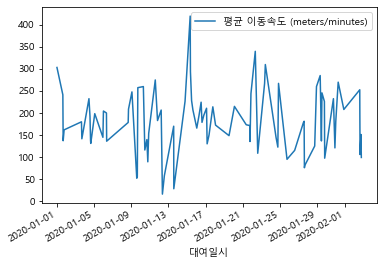

In [9]:

bike_train_speed = bike_train.values.mean()
print("%d 번 자전거의 학습 데이터상의 평균이동속도는 %.2f (m/m)이다." %(int(bike_number), bike_train_speed))
bike_train.plot()
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   83
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -469.104
Method:                       css-mle   S.D. of innovations             67.029
Date:                Fri, 04 Sep 2020   AIC                            950.208
Time:                        00:34:29   BIC                            964.721
Sample:                             1   HQIC                           956.039
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.336      0.032      0.975      -0.648       0.669
ar.L1.D.y     -0.4150      0.162     -2.566      0.012      -0.732      -0.098
ar.L2.D.y     -0.1353      0.126     -1.073      0.2

<AxesSubplot:>

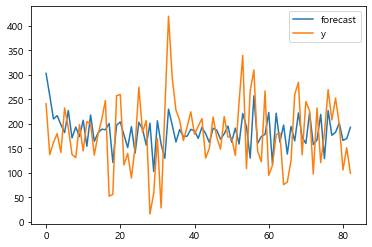

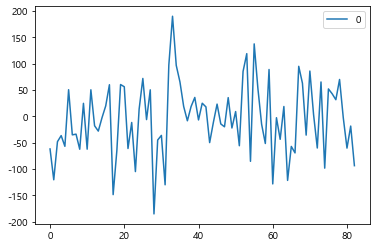

In [10]:
#이전의 값이 이후의 값에 영향을 미치는 정도인 AR(p) 모형이 2차시이고, 
# RV의 평균값이 지속적으로 증가하거나 감소하는 추세인 MA(r) 모형이 2차시이고, 
# 1차 차분이 완료되어 있는 파라미터로 
# ARIMA(2,1,2) Autogressive Integrated Moving Average 모델을 학습한다.
# Yt = α1Yt-1 + α2Yt-2 + β1εt-1 + β2εt-2 + εt
# 학습 데이터의 예측 결과와 실제 데이터를 비교한 그래프와
# 잔차의 변동을 시각화한 그래프를 첨부하였다.
 
model = ARIMA(bike_train['평균 이동속도 (meters/minutes)'].values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

fig = model_fit.plot_predict()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

14251 번 자전거의 예측 데이터상의 평균이동속도는 159.87 (m/m)이다.

모델의 평균 제곱근 편차의 값은 55.91 이다.


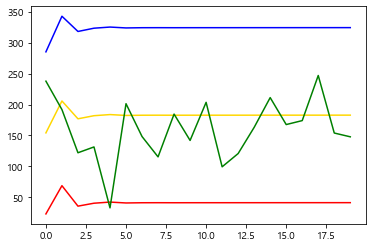

In [12]:
# 학습 데이터를 통해 학습한 모델이 예측한 예측 데이터를 산출하고,
# 좀 전에 따로 구비해두었던 테스트 데이터와 상호비교하여 모델의 정확성을 확인하였다.
# 이로써 시계열데이터를 변수로 넣으면 자전거의 평균속도가 산출되는
# ARIMA 모델이 학습되었고, 데이터의 시간을 벗어난 다른 시간대의 자전거의 평균속도를
# 구할 수 있게 되었다.
# 그래프는 모델이 예상한 최소, 최대, 그리고 평균 속도 그래프와 테스트 데이터를 시각적으로 비교하였고
# 마지막으로 추정 값 혹은 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이를 다룬
# 평균 제곱근 편차의 값을 산출하여 모델의 정확성을 측정하였다.

fore = model_fit.forecast(steps=20)

bike_test_speed = bike_test.values.mean()
pred_y = fore[0].tolist()
test_y = bike_test['평균 이동속도 (meters/minutes)'].values
pred_y_low = []
pred_y_up = []
for low_up in fore[2]:
    low = low_up[0]
    up = low_up[1]
    pred_y_low.append(low)
    pred_y_up.append(up)
    
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_low, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_up, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

rmse = sqrt(mean_squared_error(pred_y, test_y))

print("%d 번 자전거의 예측 데이터상의 평균이동속도는 %.2f (m/m)이다." %(int(bike_number), bike_test_speed))
print("\n모델의 평균 제곱근 편차의 값은 %.2f 이다." %(rmse))